In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
os.chdir("/Users/trinhha/Documents/VU AMSTERDAM/STUDY/Thesis/Code/")
from src.evaluation import compute_fidelity
from src.eda import tsne_scatter
import numpy as np

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'  # or other, 'dejavuserif'
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' serif' 'Times'

In [2]:
# Define labels for the metrics to be plotted
metric_labels = {
            "precision": "Precision",
            "recall": "Recall",
            "f1_score": "F1-Score",
            "auc": "AUC",
        }
metric_used = "AUC"

## 0. Best models

In [13]:
# Get the best baseline model
baseline = pd.read_csv("experiments/perf_summary/baseline_val_results.csv")
baseline_model = baseline.query(f'tuned_by == "{metric_used}"')["version"].astype(str).tolist()
baseline_test_perf = pd.read_csv("results/metrics/baseline.csv")
baseline_test_perf["version"] = baseline_test_perf["version"].astype(str)
baseline_best = baseline_test_perf[baseline_test_perf["version"].isin(baseline_model)]
baseline_best

,accuracy,precision,recall,f1_score,auc,version,timestamp
24,0.83713,0.585866,0.685225,0.631662,0.876369,202505080012,2025-05-13 03:21:57


In [14]:
# Read the test performance of the DP-SGD models
dpsgd = pd.read_csv("experiments/perf_summary/dpsgd_val_results.csv")
dpsgd_models = dpsgd.query(f'tuned_by == "{metric_used}"')["version"].astype(str).tolist()
dpsgd_test_perf = pd.read_csv("results/metrics/dpsgd.csv")
dpsgd_test_perf["version"] = dpsgd_test_perf["version"].astype(str)
dpsgd_best = dpsgd_test_perf[dpsgd_test_perf["version"].isin(dpsgd_models)].sort_values(by="eps", ascending=True)
display(dpsgd_best)

,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp
81,0.772454,0.450220,0.526767,0.485494,0.739987,202505161637,1.0,0.00001,2025-05-22 01:15:35
82,0.776119,0.457407,0.528908,0.490566,0.743660,202505161903,3.0,0.00001,2025-05-22 01:25:30
93,0.781182,0.468498,0.547752,0.505035,0.757946,202505180130,5.0,0.00001,2025-05-22 01:21:40


In [5]:
# Read the test performance of the DP-SGD models
posthoc_dp = pd.read_csv("experiments/perf_summary/posthoc_dp_val_results.csv")
posthoc_dp["version"] = posthoc_dp["version"].astype(str)
posthoc_dp_models = posthoc_dp.query(f'tuned_by == "{metric_used}"')["version"].tolist()
posthoc_dp_test_perf = pd.read_csv("results/metrics/posthoc_dp.csv")
posthoc_dp_test_perf["version"] = posthoc_dp_test_perf["version"].astype(str)
posthoc_dp_best = posthoc_dp_test_perf[posthoc_dp_test_perf["version"].isin(posthoc_dp_models)].sort_values(by="eps", ascending=True).merge(posthoc_dp[["version", "noise_mechanism"]], on="version", how="left")
display(posthoc_dp_best)

,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp,noise_mechanism
0,0.657327,0.262324,0.376017,0.309046,0.560740,202505262228,1,0.00001,2025-05-27 20:17:36,laplace
1,0.633761,0.225273,0.326767,0.266690,0.528071,202505272158,1,0.00001,2025-05-27 22:25:34,gaussian
2,0.690757,0.324623,0.478801,0.386918,0.639485,202505262252,3,0.00001,2025-05-27 20:33:56,laplace
3,0.649734,0.249253,0.357173,0.293610,0.560106,202505272225,3,0.00001,2025-05-27 22:48:19,gaussian
4,0.660731,0.268496,0.385439,0.316511,0.583600,202505262201,5,0.00001,2025-05-27 20:57:24,gaussian
5,0.739461,0.380602,0.443683,0.409729,0.660961,202505262316,5,0.00001,2025-05-27 21:17:56,laplace


In [ ]:
baseline_params = baseline[baseline.columns[6:-1]]
baseline_params["model"] = "Baseline"
dpsgd_params = dpsgd[dpsgd.columns[6:-1]]
dpsgd_params["model"] = "DP-SGD"

summary_params = pd.concat([baseline_params, dpsgd_params], ignore_index=True).drop(columns=["delta"])
summary_params["epsilon"] = summary_params["epsilon"].apply(lambda x: "$\ " if pd.isna(x) else f"{x:.0f}")
summary_params.sort_values(["model", "epsilon"], inplace=True)
summary_params.set_index(["model", "epsilon", "tuned_by"], inplace=True)
summary_params.reset_index(names=["Model", "eps", "Tuning objective"], inplace=True)
summary_params.fillna("-", inplace=True)
display(summary_params)

# Generate LaTeX table using the requested format
latex_table = r"""\begin{sidewaystable}
    \centering
    \caption{Final hyperparameter configurations by tuning objective}
    \begin{minipage}{\columnwidth} \footnotesize
    \vspace{-2mm}
    Summary of final hyperparameter configurations yielding the highest validation performance based on each tuning objective. Results are reported separately for each model type and privacy budgets ($\varepsilon \in \{1, 3, 5\}$).
    \vspace{2mm}
    \end{minipage}
    \label{tab:final-hyperparams}
    \scriptsize
    \begin{tabular}{llcccccccccc}
    \toprule
    \textbf{Model} & $\varepsilon$ &\textbf{Tuned by} & \textbf{Hidden dimensions} & \textbf{Batch size} & \textbf{Dropout rate} & \textbf{Learning rate} & $\lambda$ & $\gamma$ & \textbf{Threshold} & $l_2$-norm clip & \textbf{Max Epochs} \\
    \midrule
"""
model = "0"
eps = "0"
def to_latex_sci(x, precision=1):
    """Convert a float to LaTeX scientific notation."""
    if isinstance(x, str) or x == "–":
        return x
    return f"${x:.{precision}e}".replace("e", r" \times 10^{") + "}$"

# Add rows from summary_params
for _, row in summary_params.iterrows():
    if model != row["Model"]:
        latex_table += row["Model"]
    else:
        latex_table += ""
    model = row["Model"]
    if eps != row["eps"]:
        latex_table += " & " + row["eps"].replace("$\ ", "")
    else:
        latex_table += " & "
    eps = row["eps"]
    values = row.values[4:]
    values = [f"{val:.3f}".replace(".000", "") if isinstance(val, (int, float)) and (val >= 0.001 or val == 0) else to_latex_sci(val, precision=3) if isinstance(val, (int, float)) else val for val in values]
    latex_table += f" & {row['Tuning objective'].replace('Score', 'score')} & {row['hidden_dims'].replace('(', '[').replace(',)', ']').replace(')', ']')} & " + " & ".join(values) + r" \\" + "\n"
latex_table += r"""    \bottomrule
    \end{tabular}
\end{sidewaystable}"""
print(latex_table)

,Model,eps,Tuning objective,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,threshold,l2norm_pct,max_epochs
0,Baseline,$\,Precision,"(64,)",79.0,0.308206,0.042715,0.031488,0.212212,14.037385,-,-
1,Baseline,$\,Recall,[64],110.0,0.210764,0.060430,0.001106,0.999000,0.033476,-,-
2,Baseline,$\,F1-Score,[64],83.0,0.000000,0.090339,0.002620,0.999000,0.041201,-,-
3,Baseline,$\,AUC,"[64, 32]",83.0,0.000795,0.088987,0.001651,0.999000,0.046916,-,-
4,DP-SGD,1,Precision,"[64, 32]",99.0,0.263867,0.000005,0.000100,0.759931,9.374158,84.0,700.0
5,DP-SGD,1,Recall,"[64, 32]",100.0,0.219073,0.000010,0.070330,0.999000,8.011639,89.0,443.0
6,DP-SGD,1,F1-Score,"[64, 32]",79.0,0.090920,0.000010,0.023430,0.947740,4.876751,94.0,700.0
7,DP-SGD,1,AUC,"[64, 32]",88.0,0.060666,0.000029,0.046231,0.999000,5.304986,90.0,345.0
8,DP-SGD,3,Precision,"[64, 32]",93.0,0.076595,0.000005,0.100000,0.865558,16.141375,76.0,700.0
9,DP-SGD,3,Recall,"[64, 32]",64.0,0.125094,0.000007,0.002475,0.999000,0.609393,75.0,700.0


\begin{sidewaystable}[H]
    \centering
    \caption{Final hyperparameter configurations by tuning objective}
    \begin{minipage}{\columnwidth} \footnotesize
    \vspace{-2mm}
    Summary of final hyperparameter configurations yielding the highest validation performance based on each tuning objective. Results are reported separately for each model type and privacy budgets ($\varepsilon \in \{1, 3, 5\}$).
    \vspace{2mm}
    \end{minipage}
    \label{tab:final-hyperparams}
    \scriptsize
    \begin{tabular}{llcccccccccc}
    \toprule
    \textbf{Model} & $\varepsilon$ &\textbf{Tuned by} & \textbf{Hidden dimensions} & \textbf{Batch size} & \textbf{Dropout rate} & \textbf{Learning rate} & $\lambda$ & $\gamma$ & \textbf{Threshold} & $l_2$-norm clip & \textbf{Max Epochs} \\
    \midrule
Baseline &  & Precision & [64] & 79 & 0.308 & 0.043 & 0.031 & 0.212 & 14.037 & - & - \\
 &  & Recall & [64] & 110 & 0.211 & 0.060 & 0.001 & 0.999 & 0.033 & - & - \\
 &  & F1-score & [64] & 83 & 0 & 0.090 

## 1. Performance trade-off

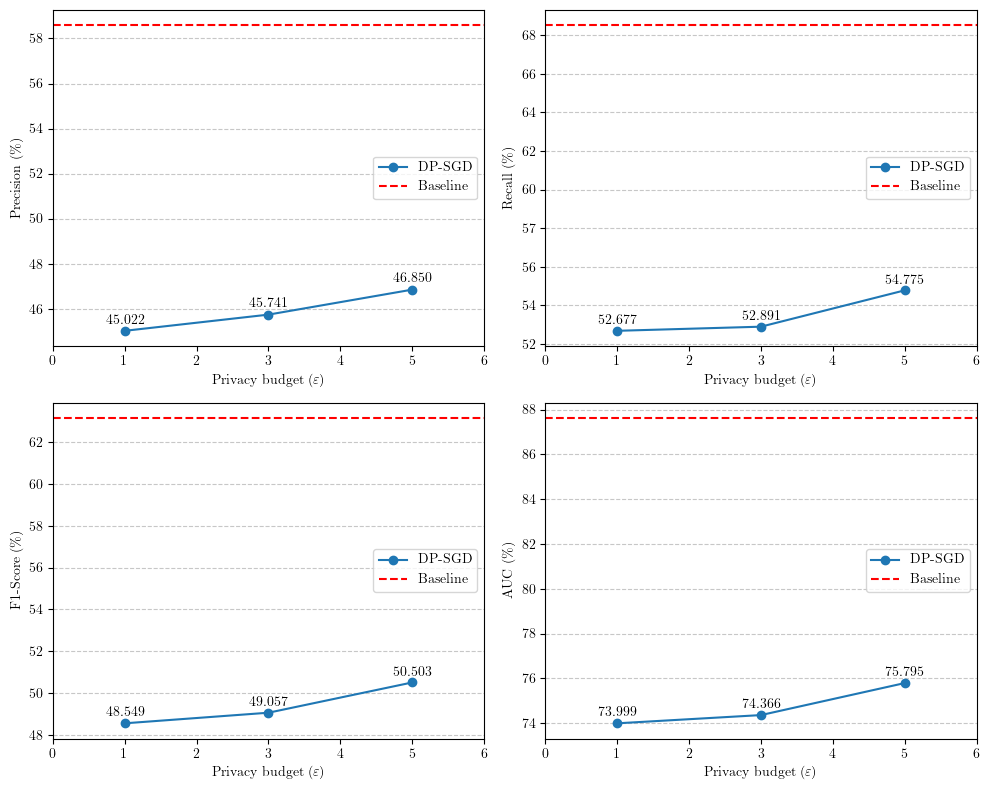

In [6]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, metric in enumerate(metric_labels.keys()):
    ax = axes[i]
    ax.plot(dpsgd_best['eps'], dpsgd_best[metric], marker='o', label='DP-SGD')
    # Add baseline data label
    ax.axhline(y=baseline_best[metric].tolist()[0], color='red', linestyle='--', label='Baseline')
    # Set x axis from 0 to 6
    ax.set_xlim(0, 6)
    # Add data labels
    for j, v in enumerate(dpsgd_best[metric]):
        ax.text(dpsgd_best['eps'].iloc[j], v + 0.002, f"{v * 100:.3f}", ha='center', va='bottom')
    ax.legend(loc='best')
    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    # Set y ticks to percentage
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(v * 100)}" for v in yticks])
    # Set y label
    ax.set_ylabel(metric_labels[metric] + " (\%)")
    # Set x label
    ax.set_xlabel(r'Privacy budget ($\varepsilon$)')

plt.tight_layout()
plt.savefig("results/figures/performance_comparison.png", dpi=300)
plt.show()

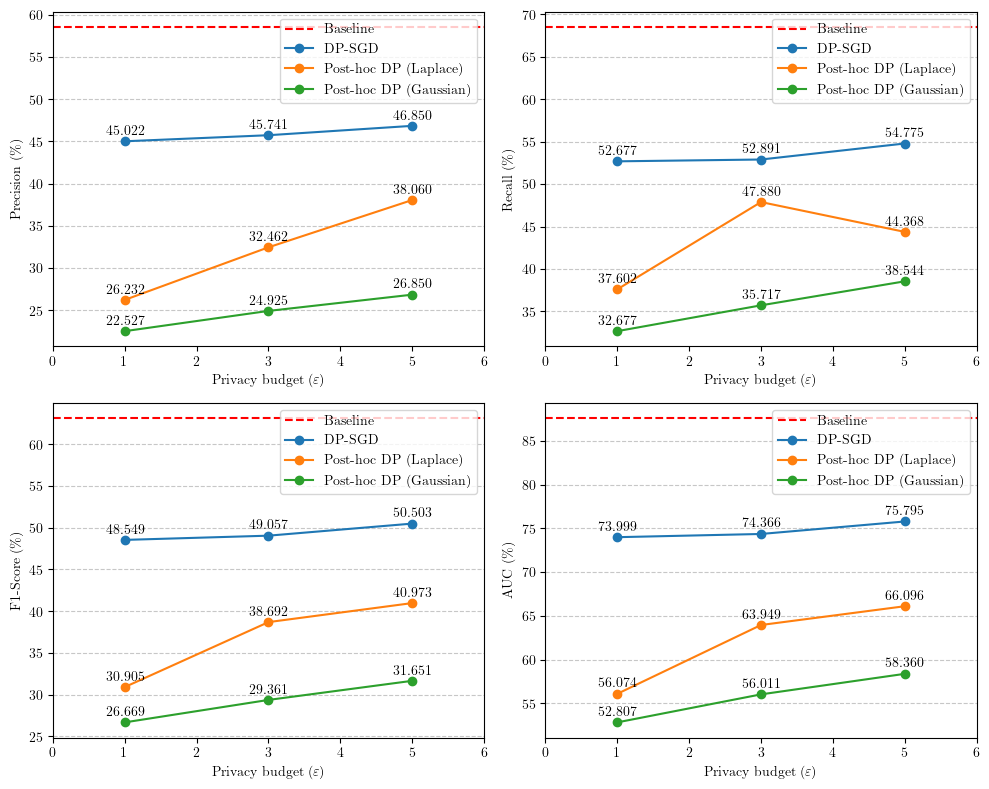

In [7]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, metric in enumerate(metric_labels.keys()):
    ax = axes[i]
    # Add baseline data label
    ax.axhline(y=baseline_best[metric].tolist()[0], color='red', linestyle='--', label='Baseline')
    
    # Plot DP-SGD
    ax.plot(dpsgd_best['eps'], dpsgd_best[metric], marker='o', label='DP-SGD')
    # Add data labels
    for j, v in enumerate(dpsgd_best[metric]):
        ax.text(dpsgd_best['eps'].iloc[j], v + 0.005, f"{v * 100:.3f}", ha='center', va='bottom')
    
    # Plot Post-hoc DP
    for noise_mechanism in posthoc_dp_best["noise_mechanism"].unique():
        # Filter posthoc_dp_best for the current noise mechanism
        filtered_posthoc_dp = posthoc_dp_best[posthoc_dp_best["noise_mechanism"] == noise_mechanism]
        if not filtered_posthoc_dp.empty:
            ax.plot(filtered_posthoc_dp['eps'], filtered_posthoc_dp[metric], marker='o', label=f'Post-hoc DP ({noise_mechanism.capitalize()})')
            for j, v in enumerate(filtered_posthoc_dp[metric]):
                ax.text(filtered_posthoc_dp['eps'].iloc[j], v + 0.005, f"{v * 100:.3f}", ha='center', va='bottom')
    # Set x axis from 0 to 6
    ax.set_xlim(0, 6)
    # Add legend
    ax.legend(loc='best')
    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    # Set y ticks to percentage
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(v * 100)}" for v in yticks])
    # Set y label
    ax.set_ylabel(metric_labels[metric] + " (\%)")
    # Set x label
    ax.set_xlabel(r'Privacy budget ($\varepsilon$)')

plt.tight_layout()
plt.savefig("results/figures/performance_comparison.png", dpi=300)
plt.show()

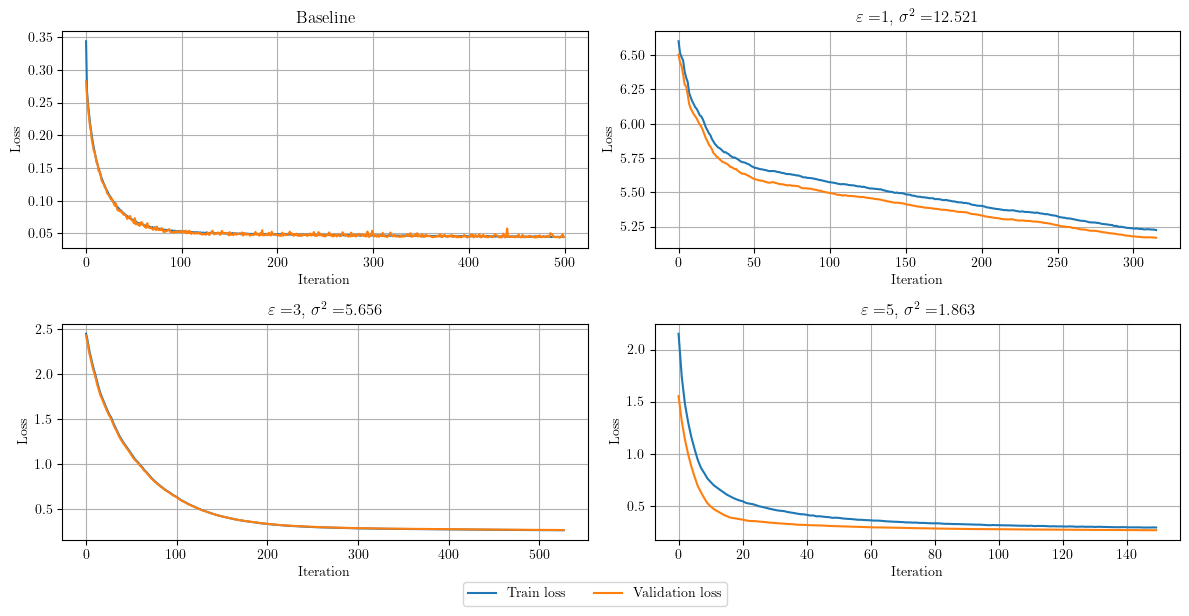

In [8]:
# Layout: 2×2 grid with a subplot for each model
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes = axes.flatten()

def plot_loss(ax, results_df, epsilon=None, noise=None):
    # Plot loss on the left y-axis
    train = ax.plot(results_df.index, results_df["train_loss"], label='Train loss')
    val = ax.plot(results_df.index, results_df["val_loss"], label='Validation loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.tick_params(axis='y')
    if epsilon is not None:
        ax.set_title(r"$\varepsilon =$" + f"{epsilon:.0f}" + r", $\sigma^2 =$" + f"{noise:.3f}")
    else:
        ax.set_title("Baseline")
    ax.grid(True)

    lns = train + val

    return ax, lns

ax = axes[0]
# Plot baseline performance
baseline_version = baseline_best["version"].astype(str).tolist()[0]
results_df = pd.read_csv(f"experiments/tracking/{baseline_version}_baseline.csv")
ax, lns = plot_loss(ax, results_df)

# Iterate through the rows of dpsgd_best DataFrame
for i, row in dpsgd_best.reset_index(drop=True).iterrows():
    # Flatten the axes for easy indexing
    ax = axes[i + 1]
    # Extract the version and epsilon from the row
    version = row["version"]
    epsilon = row["eps"]

    # Read result file
    folder = "experiments/tracking"

    # Read the existing files with the same version prefix
    pattern = os.path.join(folder, f"{version}_noise*.csv")
    for file in glob.glob(pattern):
        results_df = pd.read_csv(file)
        noise = float(file.split("noise")[-1].split(".csv")[0])

    # Plot loss
    ax, lns = plot_loss(ax, results_df, epsilon, noise)

# added these three lines
labs = [l.get_label() for l in lns]
fig.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.03),
           ncol=3)

plt.tight_layout()
plt.savefig("results/figures/convergence_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Compute fidelity
# Read the baseline predictions
baseline_predictions = pd.read_feather(f"experiments/predictions/baseline/{baseline_version}_pred.feather")
# Define a function to compute fidelity for each DP-SGD version
def get_fidelity(model_type, dpsgd_version):
    dpsgd_predictions = pd.read_feather(f"experiments/predictions/{model_type}/{dpsgd_version}_pred.feather")
    fidelity = compute_fidelity(baseline_predictions, dpsgd_predictions)
    return fidelity
# Get the fidelity of the DP-SGD models
dpsgd_best["fidelity"] = dpsgd_best["version"].apply(lambda x: get_fidelity("dpsgd", x))
metric_labels["fidelity"] = "Fidelity"
display(dpsgd_best)
# Get the fidelity of the Post-hoc DP models
posthoc_dp_best["fidelity"] = posthoc_dp_best["version"].apply(lambda x: get_fidelity("posthoc_dp", x))
posthoc_dp_gaussian_best = posthoc_dp_best[posthoc_dp_best["noise_mechanism"] == "gaussian"]
posthoc_dp_laplace_best = posthoc_dp_best[posthoc_dp_best["noise_mechanism"] == "laplace"]
display(posthoc_dp_gaussian_best[dpsgd_best.columns.tolist()])
display(posthoc_dp_laplace_best[dpsgd_best.columns.tolist()])

,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp,fidelity
81,0.772454,0.450220,0.526767,0.485494,0.739987,202505161637,1.0,0.00001,2025-05-22 01:15:35,0.741032
82,0.776119,0.457407,0.528908,0.490566,0.743660,202505161903,3.0,0.00001,2025-05-22 01:25:30,0.741730
93,0.781182,0.468498,0.547752,0.505035,0.757946,202505180130,5.0,0.00001,2025-05-22 01:21:40,0.746967


,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp,fidelity
1,0.633761,0.225273,0.326767,0.266690,0.528071,202505272158,1,0.00001,2025-05-27 22:25:34,0.61613
3,0.649734,0.249253,0.357173,0.293610,0.560106,202505272225,3,0.00001,2025-05-27 22:48:19,0.62931
4,0.660731,0.268496,0.385439,0.316511,0.583600,202505262201,5,0.00001,2025-05-27 20:57:24,0.63926


,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp,fidelity
0,0.657327,0.262324,0.376017,0.309046,0.560740,202505262228,1,0.00001,2025-05-27 20:17:36,0.635856
2,0.690757,0.324623,0.478801,0.386918,0.639485,202505262252,3,0.00001,2025-05-27 20:33:56,0.670682
5,0.739461,0.380602,0.443683,0.409729,0.660961,202505262316,5,0.00001,2025-05-27 21:17:56,0.713799


In [10]:
# Create a summary table
summary_table = pd.concat([baseline_best, dpsgd_best], ignore_index=True).set_index("eps")[["precision", "recall", "f1_score", "auc", "fidelity"]].T
# Rename the index to match the metric labels
summary_table.index = [metric_labels[metric] for metric in summary_table.index]
# Given a set of epsilon values
epsilons = {1, 3, 5}
# Create the list of tuples and set the MultiIndex
column_tuples = [("Baseline", "")] + [("DP-SGD", eps) for eps in sorted(epsilons)]
summary_table.columns = pd.MultiIndex.from_tuples(column_tuples)
summary_table.fillna("--", inplace=True)
display(summary_table)

# Format LaTeX rows
latex_rows = []
for idx, row in summary_table.iterrows():
    formatted = " & ".join(f"{v * 100:.3f}" if v != "--" else "--" for v in row)
    latex_rows.append(f"{idx} & {formatted} \\\\")

# Extract top-level and sub-level headers
multi_cols = summary_table.columns
top_header = [""] + [f"\\textbf{{{col[0]}}}" for col in multi_cols]
sub_header = ["\\textbf{Metric}"] + [f"\\textbf{{{col[1]}}}" if col[1] != "" else "" for col in multi_cols]

# Compose the LaTeX table
latex_table = r"""
\begin{table}[!t]
    \centering
    \caption{Summary of validation performance (\%) across baseline and DP-SGD models}
    \label{tab:summary-performance}
    \begin{tabular}{lcccc}
    \toprule
& \textbf{Baseline} & \multicolumn{"""+ str(len(multi_cols) - 1) + r"""}{c}{\textbf{DP-SGD}} \\
\cmidrule(lr){3-"""+ str(1 + len(multi_cols)) + r"""}
""" + " & ".join(sub_header) + r""" \\
    \midrule
""" + "\n".join(latex_rows) + r"""
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using F1-score as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points.}
    \end{table}"""

print(latex_table)

Baseline    DP-SGD                    
                            1         3         5
Precision  0.585866  0.450220  0.457407  0.468498
Recall     0.685225  0.526767  0.528908  0.547752
F1-Score   0.631662  0.485494  0.490566  0.505035
AUC        0.876369  0.739987  0.743660  0.757946
Fidelity         --  0.741032  0.741730  0.746967


\begin{table}[!t]
    \centering
    \caption{Summary of validation performance (\%) across baseline and DP-SGD models}
    \label{tab:summary-performance}
    \begin{tabular}{lcccc}
    \toprule
& \textbf{Baseline} & \multicolumn{3}{c}{\textbf{DP-SGD}} \\
\cmidrule(lr){3-5}
\textbf{Metric} &  & \textbf{1} & \textbf{3} & \textbf{5} \\
    \midrule
Precision & 58.587 & 45.022 & 45.741 & 46.850 \\
Recall & 68.522 & 52.677 & 52.891 & 54.775 \\
F1-Score & 63.166 & 48.549 & 49.057 & 50.503 \\
AUC & 87.637 & 73.999 & 74.366 & 75.795 \\
Fidelity & -- & 74.103 & 74.173 & 74.697 \\
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using F1-score as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points.}
    \end{table}


In [11]:
# Create a summary table
summary_table = pd.concat([baseline_best, dpsgd_best, posthoc_dp_gaussian_best, posthoc_dp_laplace_best], ignore_index=True).set_index("eps")[["precision", "recall", "f1_score", "auc", "fidelity"]].T
# Rename the index to match the metric labels
summary_table.index = [metric_labels[metric] for metric in summary_table.index]
# Given a set of epsilon values
epsilons = {1, 3, 5}
# Create the list of tuples and set the MultiIndex
column_tuples = [("Baseline", "", "")] + [("DP-SGD", "", eps) for eps in sorted(epsilons)] + [("Post-hoc DP", noise, eps) for noise in ["Gaussian", "Laplace"] for eps in sorted(epsilons)]
summary_table.columns = pd.MultiIndex.from_tuples(column_tuples)
summary_table.fillna("--", inplace=True)
display(summary_table)

# Format LaTeX rows
latex_rows = []
for idx, row in summary_table.iterrows():
    formatted = " & ".join(f"{v * 100:.3f}" if v != "--" else "--" for v in row)
    latex_rows.append(f"{idx} & {formatted} \\\\")

# Extract top-level and sub-level headers
multi_cols = summary_table.columns
top_header = [""] + [f"\\textbf{{{col[0]}}}" for col in multi_cols]
sub_header = ["\\textbf{Metric}"] + [f"\\textbf{{{col[2]}}}" if col[2] != "" else "" for col in multi_cols]

# Compose the LaTeX table
latex_table = r"""
\begin{table}[!t]
    \centering
    \caption{Summary of validation performance (\%) across baseline, DP-SGD, and post-hoc DP models}
    \label{tab:summary-performance}
    \begin{tabular}{lcccccccccc}
    \toprule
& \textbf{Baseline} & \multicolumn{"""+ str(len(epsilons)) + r"""}{c}{\textbf{DP-SGD}} & \multicolumn{"""+ str(len(epsilons)*2) + r"""}{c}{\textbf{Post-hoc DP}} \\
\cmidrule(lr){"""+ str(2 + len(epsilons) + 1) + r"""-"""+ str(2 + len(epsilons)*3) + r"""}
& & & & & \multicolumn{"""+ str(len(epsilons)) + r"""}{c}{\textbf{Gaussian}} & \multicolumn{"""+ str(len(epsilons)) + r"""}{c}{\textbf{Laplace}} \\
\cmidrule(lr){3-"""+ str(2 + len(epsilons)) + r"""} \cmidrule(lr){"""+ str(2 + len(epsilons) + 1) + r"""-"""+ str(2 + len(epsilons)*2) + r"""} \cmidrule(lr){"""+ str(2 + len(epsilons)*2 + 1) + r"""-"""+ str(2 + len(epsilons)*3) + r"""} \\
""" + " & ".join(sub_header) + r""" \\
    \midrule
""" + "\n".join(latex_rows) + r"""
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using F1-score as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points.}
    \end{table}"""

print(latex_table)

Baseline    DP-SGD                     Post-hoc DP            \
                                                     Gaussian             
                            1         3         5           1         3   
Precision  0.585866  0.450220  0.457407  0.468498    0.225273  0.249253   
Recall     0.685225  0.526767  0.528908  0.547752    0.326767  0.357173   
F1-Score   0.631662  0.485494  0.490566  0.505035    0.266690  0.293610   
AUC        0.876369  0.739987  0.743660  0.757946    0.528071  0.560106   
Fidelity         --  0.741032  0.741730  0.746967    0.616130  0.629310   

                                                   
                      Laplace                      
                  5         1         3         5  
Precision  0.268496  0.262324  0.324623  0.380602  
Recall     0.385439  0.376017  0.478801  0.443683  
F1-Score   0.316511  0.309046  0.386918  0.409729  
AUC        0.583600  0.560740  0.639485  0.660961  
Fidelity   0.639260  0.635856  0.670682  0.713799


\begin{table}[!t]
    \centering
    \caption{Summary of validation performance (\%) across baseline, DP-SGD, and post-hoc DP models}
    \label{tab:summary-performance}
    \begin{tabular}{lcccccccccc}
    \toprule
& \textbf{Baseline} & \multicolumn{3}{c}{\textbf{DP-SGD}} & \multicolumn{6}{c}{\textbf{Post-hoc DP}} \\
\cmidrule(lr){6-11}
& & & & & \multicolumn{3}{c}{\textbf{Gaussian}} & \multicolumn{3}{c}{\textbf{Laplace}} \\
\cmidrule(lr){3-5} \cmidrule(lr){6-8} \cmidrule(lr){9-11} \\
\textbf{Metric} &  & \textbf{1} & \textbf{3} & \textbf{5} & \textbf{1} & \textbf{3} & \textbf{5} & \textbf{1} & \textbf{3} & \textbf{5} \\
    \midrule
Precision & 58.587 & 45.022 & 45.741 & 46.850 & 22.527 & 24.925 & 26.850 & 26.232 & 32.462 & 38.060 \\
Recall & 68.522 & 52.677 & 52.891 & 54.775 & 32.677 & 35.717 & 38.544 & 37.602 & 47.880 & 44.368 \\
F1-Score & 63.166 & 48.549 & 49.057 & 50.503 & 26.669 & 29.361 & 31.651 & 30.905 & 38.692 & 40.973 \\
AUC & 87.637 & 73.999 & 74.366 & 75.795 & 52.807 & 

'# Draw the canvas, copy contents, and close temp\ntemp_fig = plt.figure()\ntsne = plot_tsne(0, "baseline", baseline_version)\ntemp_fig.canvas.draw()\nimage = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype=\'uint8\')\nimage = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))\nplt.close(temp_fig)\n# Show the image in the target subplot\naxes[0].imshow(image)\naxes[0].axis("off")\nfor i, row in dpsgd_best.reset_index(drop=True).iterrows():\n    # Extract the version from the row\n    version = row["version"]\n    # Plot t-SNE\n    temp_fig = plt.figure()\n    tsne = plot_tsne(i + 1, "dpsgd", version)\n    temp_fig.canvas.draw()\n    image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype=\'uint8\')\n    image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))\n    plt.close(temp_fig)\n    # Show the image in the target subplot\n    axes[i].imshow(image)\n    axes[i].axis("off")\n\nplt.tight_layout()\nplt.show()'

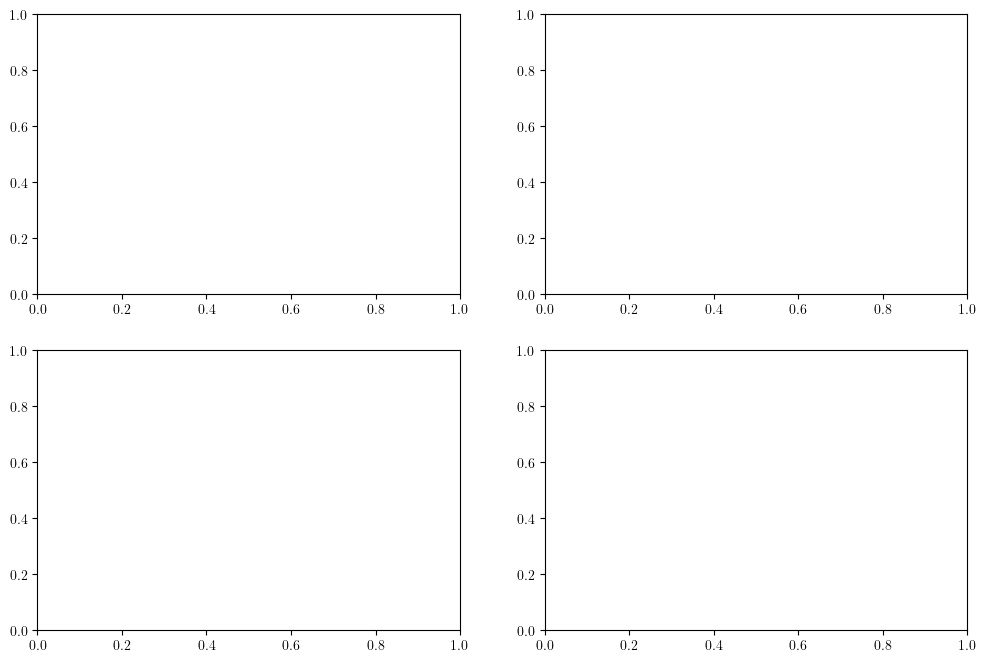

In [12]:
# Layout: 2×2 grid with a subplot for each model
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

def plot_tsne(ax_i, model_type, version):   
    # Read the predictions
    predictions = pd.read_feather(f"experiments/predictions/{model_type}/{version}_pred.feather")
    # Read the features
    features = pd.read_feather(f"experiments/predictions/{model_type}/{version}_recons.feather")
    # Create the scatter plot
    tsne = tsne_scatter(features.values, predictions.anomaly.values, dimensions=2)
    tsne.savefig(f"results/figures/{model_type}_{version}_tsne.png", dpi=300)
    return tsne

"""# Draw the canvas, copy contents, and close temp
temp_fig = plt.figure()
tsne = plot_tsne(0, "baseline", baseline_version)
temp_fig.canvas.draw()
image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype='uint8')
image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))
plt.close(temp_fig)
# Show the image in the target subplot
axes[0].imshow(image)
axes[0].axis("off")
for i, row in dpsgd_best.reset_index(drop=True).iterrows():
    # Extract the version from the row
    version = row["version"]
    # Plot t-SNE
    temp_fig = plt.figure()
    tsne = plot_tsne(i + 1, "dpsgd", version)
    temp_fig.canvas.draw()
    image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(temp_fig)
    # Show the image in the target subplot
    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()"""